In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np 
import matplotlib.pyplot as plt

from lenspack.peaks import find_peaks2d, peaks_histogram
import pandas as pd

from load_data import *
from functions import *
from hybridate import *
from filters import *
from jacknife_resampling import *

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


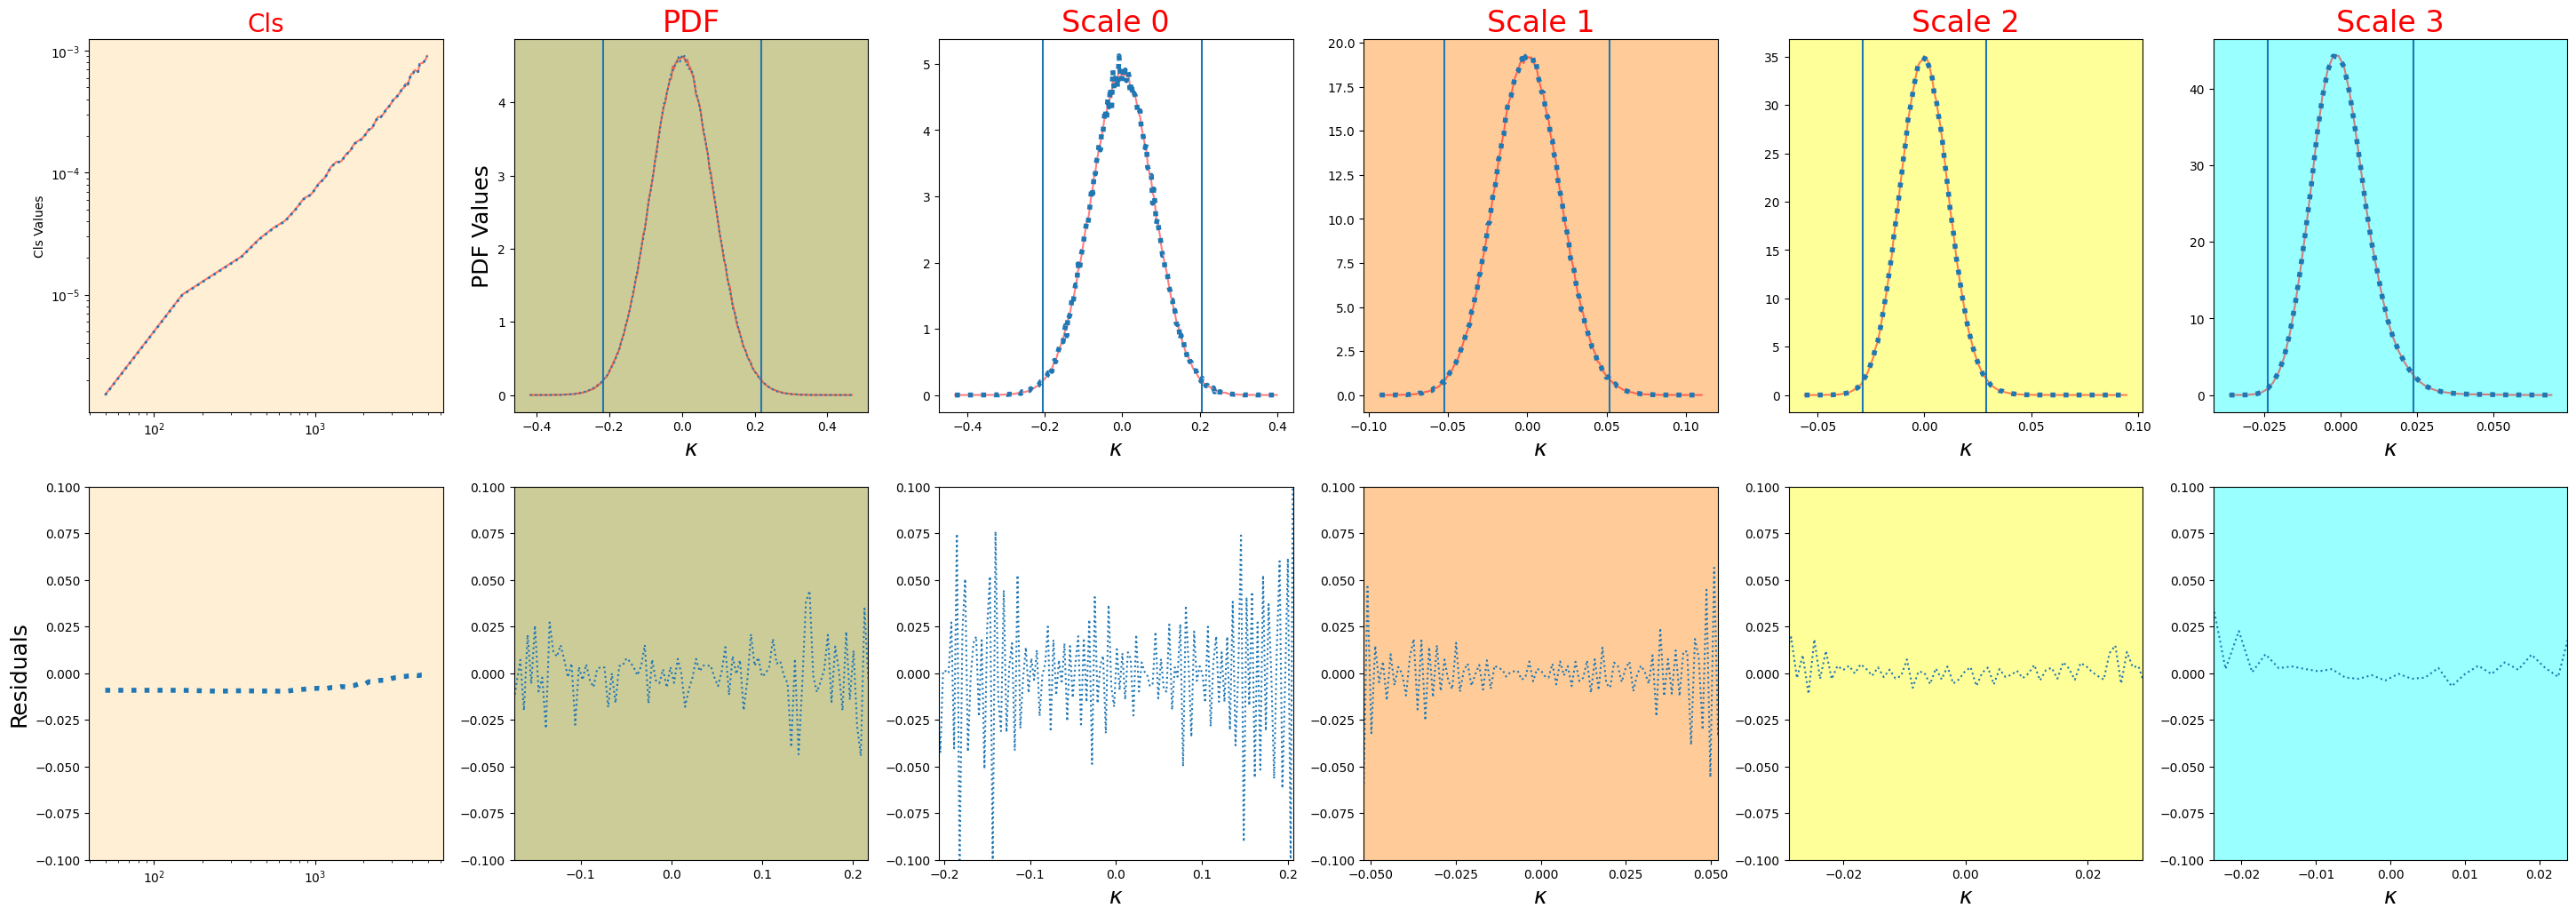

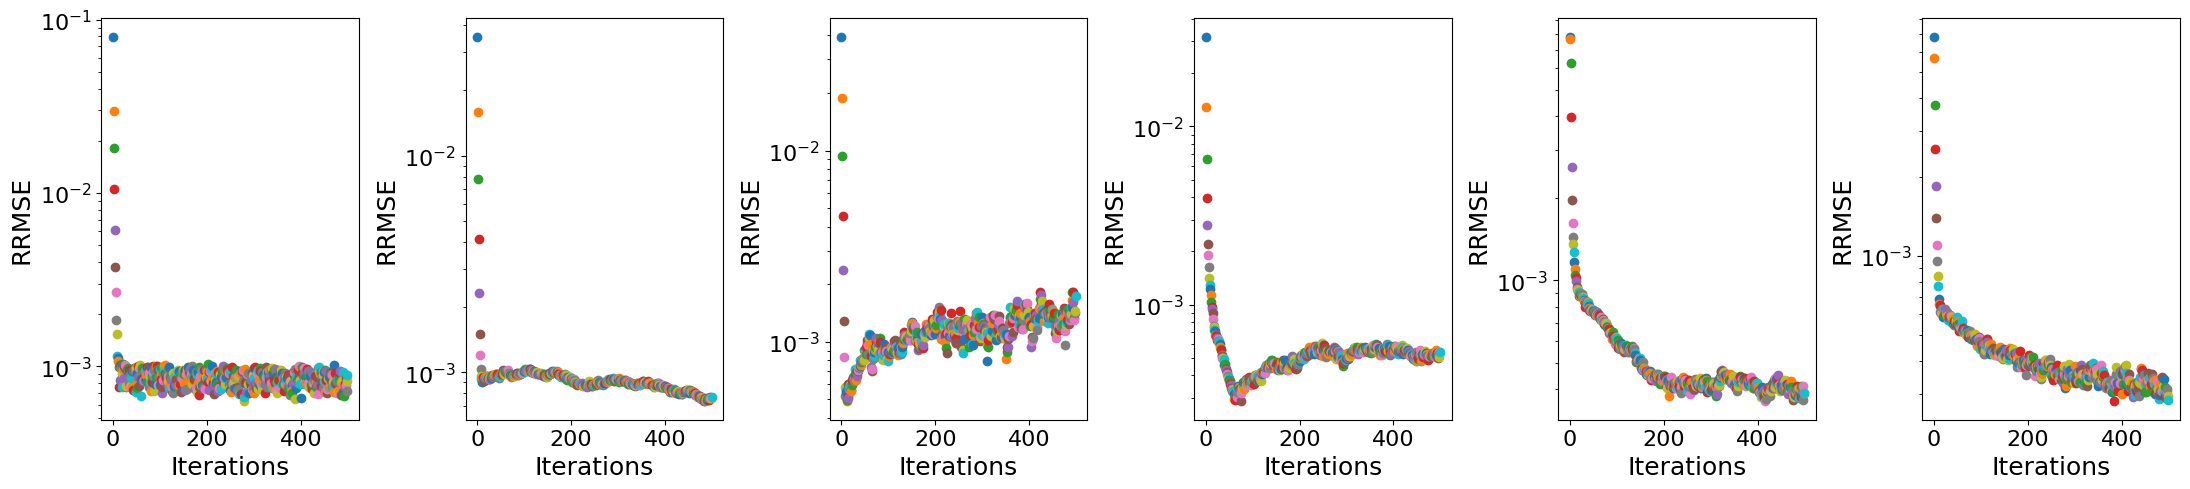

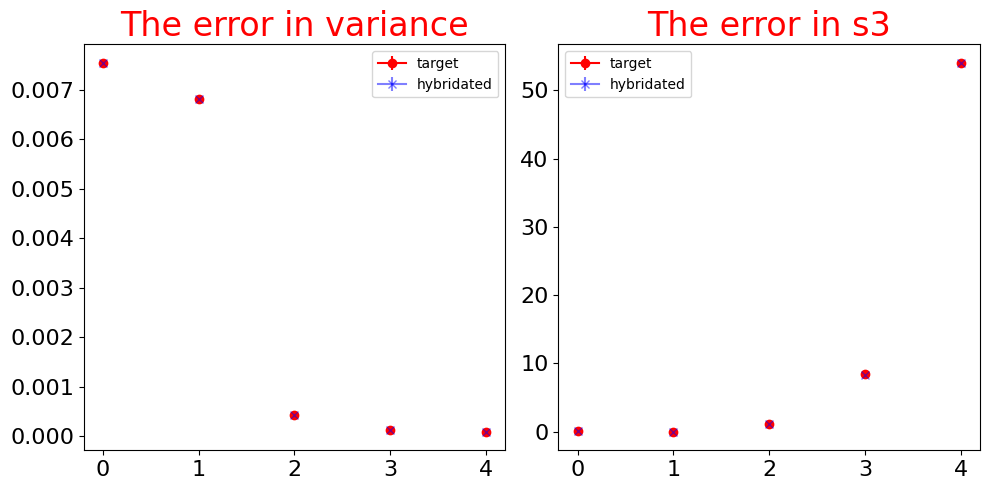

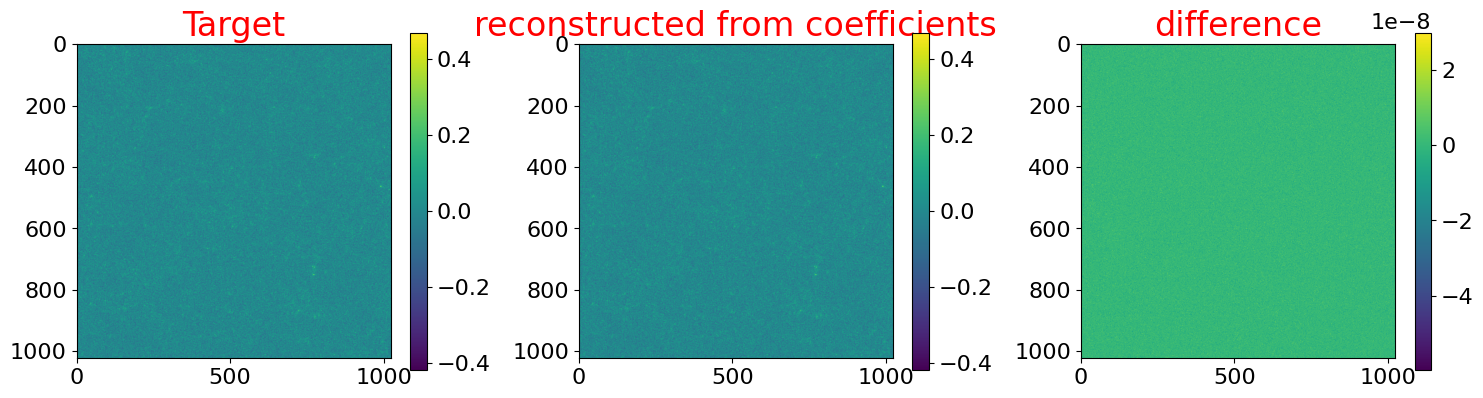

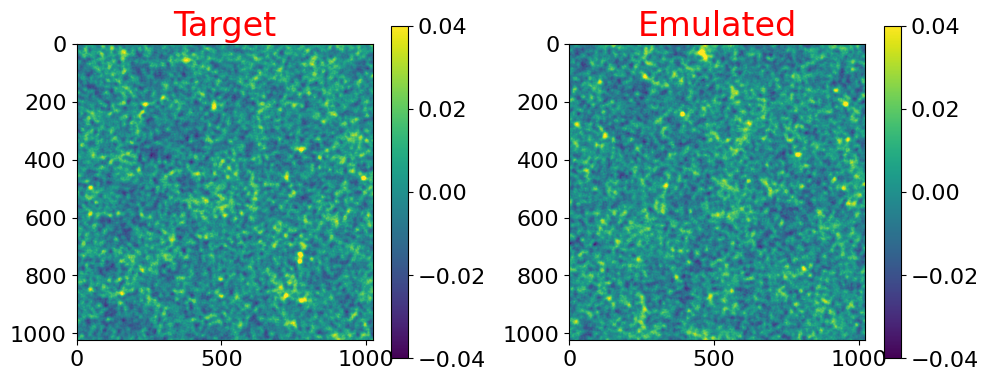

/tmp/ipykernel_1686797/4286805779.py:210: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


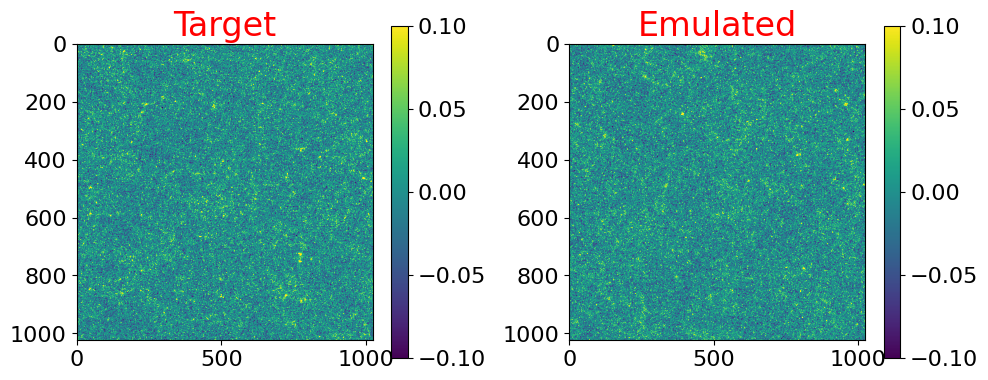

In [2]:
no_scales = 3
start = 76
end = 76
file_nos = np.arange(start, end+1)
fig, axs = plt.subplots(2, no_scales + 3, figsize=(36, 12))
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.titlecolor'] ='red'

moments_target_full = np.zeros((len(file_nos), 5))
moments_target_starlet= np.zeros((no_scales+1, len(file_nos), 5))
moments_hybridated_full = np.zeros((len(file_nos), 5))
moments_hybridated_starlet= np.zeros((no_scales+1, len(file_nos), 5))
pdf_bins = np.array([220, 260, 180, 160, 60, 40,150])
filter = 'tophat'
no_iterations = 500
for i, file_no in enumerate(file_nos):
    print(f"Iteration {i}", end='\r')
    # print(i, file_no)
    results = hybridate(redshift=2.007, file_number=start,model_name="model_one",ell_min=0, ell_max=5e3, cls_bins=50, nscales=no_scales, pdf_bins=pdf_bins, no_iterations=no_iterations, plot=True,filter=filter)
    target = results["target"]
    angle = results["angle"]
    nscales = results["nscales"]
    ell_min = results["ell_min"]
    ell_max = results["ell_max"]
    cls_bins = results["cls_bins"]
    pdf_bins = results["pdf_bins"]
    target_starlet_cls = results["target_starlet_cls"]
    target_ell_edges = results["target_ell_edges"]
    target_ell_bins = results["target_ell_bins"]
    target_cls_values = results["target_cls_values"]
    target_starlet = results["target_starlet"]
    target_edges = results["target_edges"]
    target_bin_centers = results["target_bin_centers"]
    target_pdf = results["target_pdf"]
    target_cdf = results["target_cdf"]
    target_starlet_edges = results["target_starlet_edges"]
    target_starlet_bin_centers = results["target_starlet_bin_centers"]
    target_starlet_pdf = results["target_starlet_pdf"]
    target_starlet_cdf = results["target_starlet_cdf"]
    target_starlet_cls = results["target_starlet_cls"]
    corrected_full_map = results["hybridated_map"]
    
    corrected_ell_edges, corrected_ell_bins, corrected_cls_values = calculate_Cls(corrected_full_map, angle, ell_min, ell_max, cls_bins)
    corrected_edges, corrected_bin_centers, corrected_pdf = calculate_pdf(corrected_full_map, target_edges)

    if filter=="starlet":
        corrected_wavelet = starlet_decompose(corrected_full_map, nscales)
    else:
        corrected_wavelet = tophatdecompose(corrected_full_map, nscales)
    corrected_starlet_edges = []
    corrected_starlet_bin_centers = []
    corrected_starlet_pdf = []
    corrected_starlet_cls = []
    # moments_target_full[i-1] = get_moments(target_bin_centers, target_pdf)
    moments_hybridated_full[i] = get_moments(corrected_bin_centers, corrected_pdf)
    
    for scale in range(nscales + 1):
        edges, bin_centers, counts = calculate_pdf(corrected_wavelet[scale], target_starlet_edges[scale])
        corrected_starlet_edges.append(edges)
        corrected_starlet_bin_centers.append(bin_centers)
        corrected_starlet_pdf.append(counts)
        corrected_starlet_cls.append(calculate_Cls(corrected_wavelet[scale], angle, ell_min, ell_max, cls_bins)[2])
        moments_hybridated_starlet[scale, i] = get_moments(bin_centers, counts)
        # moments_target_starlet[scale, i-1] = get_moments(target_starlet_bin_centers[scale], target_starlet_pdf[scale])
    
    axs[0,0].loglog(target_ell_bins, (target_ell_bins)*(target_ell_bins+1)*target_cls_values/(2*np.pi), label="Target Cls", c="r", alpha=0.5)
    axs[0,0].loglog(corrected_ell_bins, corrected_ell_bins*(corrected_ell_bins+1)*corrected_cls_values/(2*np.pi), label="emulated", ls=":", lw=2)
    axs[0,0].set_ylabel("Cls Values")
    axs[0,0].set_title("Cls", fontsize=20)
    
    axs[0,1].plot(target_bin_centers, target_pdf, label="Target PDF", c="r",alpha=0.5)
    axs[0,1].set_ylabel("PDF Values", fontsize=18)
    axs[0,1].set_xlabel(r"$\kappa$", fontsize=18)
    axs[0,1].set_title("PDF")
    axs[0,1].plot(corrected_bin_centers, corrected_pdf, label="emulated", ls=":")
    axs[0,1].axvline(np.mean(target) - 2.5 * np.std(target),0,1)
    axs[0,1].axvline(np.mean(target) + 2.5 * np.std(target),0,1)
    
    for scale in range(nscales + 1):
        # axs[0,0].plot(corrected_ell_bins, corrected_ell_bins*(corrected_ell_bins+1)*corrected_starlet_cls[scale]/(2*np.pi), ls=":", lw=2)
        # axs[0,0].plot(corrected_ell_bins, corrected_ell_bins*(corrected_ell_bins+1)*target_starlet_cls[scale]/(2*np.pi), c="g", alpha=0.5)
        
        axs[0,2+scale].plot(target_starlet_bin_centers[scale], target_starlet_pdf[scale], label="target", c="r", alpha=0.5)
        axs[0,2+scale].plot(corrected_starlet_bin_centers[scale], corrected_starlet_pdf[scale], label=f'Emulated', ls=":",lw=4)
        axs[0,2+scale].set_title(f"Scale {scale}")
        axs[0,2+scale].axvline(np.mean(target_starlet[scale]) - 2.5 * np.std(target_starlet[scale]),0,1)
        axs[0,2+scale].axvline(np.mean(target_starlet[scale]) + 2.5 * np.std(target_starlet[scale]),0,1)
        axs[0,2+scale].set_xlabel(r"$\kappa$", fontsize=18)    
        axs[1,2+scale].plot(corrected_starlet_bin_centers[scale], (corrected_starlet_pdf[scale] / target_starlet_pdf[scale]) - 1, label="emulated", ls=":")
        # axs[1,2+scale].set_ylabel("Residual", fontsize=18)
        axs[1,2+scale].set_xlabel(r"$\kappa$", fontsize=18)    
        axs[1,2+scale].set_xlim(np.mean(target_starlet[scale]) - 2.5 * np.std(target_starlet[scale]), np.mean(target_starlet[scale]) + 2.5 * np.std(target_starlet[scale]))
        axs[1,2+scale].set_ylim(-0.1, 0.1)
        
    axs[1,0].plot(corrected_ell_bins, (corrected_cls_values - target_cls_values)/target_cls_values, ls=":", label="emulated", lw=4)
    axs[1,0].set_ylim(-0.1,0.1)
    axs[1,0].set_xscale("log")
    axs[1,0].set_ylabel("Residuals", fontsize=18)

    # Plot PDF
    axs[1,1].plot(corrected_bin_centers, (corrected_pdf / target_pdf) - 1, label="emulated", ls=":")
    axs[1,1].set_ylim(-0.1, 0.1)
    axs[1,1].set_xlim(np.mean(target) - 2. * np.std(target), np.mean(target) + 2.5 * np.std(target))
    plt.tight_layout()
    
    # data, angle_ = load_data_mnu(redshift=1.5, file_number=file_no, model_name="model_one")
    data, angle_ = load_data(file_no)
    target_results = get_target_values(data, angle_, ell_min, ell_max, cls_bins, nscales, pdf_bins, filter=filter)

    target = target_results["target"]
    angle = target_results["angle"]
    nscales = target_results["nscales"]
    ell_min = target_results["ell_min"]
    ell_max = target_results["ell_max"]
    cls_bins = target_results["cls_bins"]
    pdf_bins = target_results["pdf_bins"]
    target_starlet_cls = target_results["target_starlet_cls"]
    target_ell_edges = target_results["target_ell_edges"]
    target_ell_bins = target_results["target_ell_bins"]
    target_cls_values = target_results["target_cls_values"]
    target_starlet = target_results["target_starlet"]
    target_edges = target_results["target_edges"]
    target_bin_centers = target_results["target_bin_centers"]
    target_pdf = target_results["target_pdf"]
    target_cdf = target_results["target_cdf"]
    target_starlet_edges = target_results["target_starlet_edges"]
    target_starlet_bin_centers = target_results["target_starlet_bin_centers"]
    target_starlet_pdf = target_results["target_starlet_pdf"]
    target_starlet_cdf = target_results["target_starlet_cdf"]
    moments_target_full[i] = get_moments(target_bin_centers, target_pdf)
    for scale in range(nscales + 1):
        moments_target_starlet[scale, i] = get_moments(target_starlet_bin_centers[scale], target_starlet_pdf[scale])
        
# Define a list of colors for the backgrounds
colors = ["#FFEFD5", "#CCCC99", "#FFFFFF", "#FFCC99", "#FFFF99", "#99FFFF", "#99FFCC", "#FF99CC", "#FFCCFF", "#99CC99"]

# Iterate over each subplot and set a different background color
for j in range(no_scales + 3):
    c = colors[j]
    axs[0, j].set_facecolor(c) 
    axs[1, j].set_facecolor(c)
# plt.savefig("plots/"+filter+str(no_iterations)+"_cls_pdf.png")

# fig, ax = plt.subplots(1, no_scales+2, figsize=(22, 10)) 
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("The error in variance")
moment = 1
plt.errorbar(0, np.mean(moments_target_full[:,moment], axis=0), yerr=np.std(moments_target_full[:,moment], axis=0),color="r", marker="o", label="target")
plt.errorbar(0, np.mean(moments_hybridated_full[:,moment], axis=0), yerr=np.std(moments_hybridated_full[:,moment], axis=0), color='blue', marker="x", alpha=0.5, label="hybridated")

for scale in range(nscales + 1):
    plt.errorbar(scale+1, np.mean(moments_target_starlet[scale, :,moment], axis=0), yerr=np.std(moments_target_starlet[scale,:,moment], axis=0),color="r", marker="o")
    plt.errorbar(scale+1, np.mean(moments_hybridated_starlet[scale,:,moment], axis=0), yerr=np.std(moments_hybridated_starlet[scale,:,moment], axis=0), color='blue', marker="x", alpha=0.5)
plt.legend()

plt.subplot(1,2,2)
plt.title("The error in s3")
moment = 2
plt.errorbar(0, np.mean(moments_target_full[:,moment], axis=0), yerr=np.std(moments_target_full[:,moment], axis=0),color="r", marker="o", label="target")
plt.errorbar(0, np.mean(moments_hybridated_full[:,moment], axis=0), yerr=np.std(moments_hybridated_full[:,moment], axis=0), color='blue', marker="x", alpha=0.5, label="hybridated")

for scale in range(nscales + 1):
    plt.errorbar(scale+1, np.mean(moments_target_starlet[scale, :,moment], axis=0), yerr=np.std(moments_target_starlet[scale,:,moment], axis=0),color="r", marker="o")
    plt.errorbar(scale+1, np.mean(moments_hybridated_starlet[scale,:,moment], axis=0), yerr=np.std(moments_hybridated_starlet[scale,:,moment], axis=0), color='blue', marker="x", alpha=0.5)
plt.legend()
plt.tight_layout()
# plt.savefig("plots/"+filter+str(no_iterations)+"_stats_compare.png")

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title("Target")
plt.imshow(target)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("reconstructed from coefficients")
plt.imshow(np.sum(target_starlet, axis=0))
plt.colorbar()

plt.subplot(1,3,3)
plt.title("difference")
plt.imshow(target-np.sum(target_starlet, axis=0))
plt.colorbar() 
plt.tight_layout()
# plt.savefig("plots/"+filter+str(no_iterations)+"_reconstruction.png")
plt.show()

plt.figure(figsize=(10,4))
vmin = -0.04
vmax = -vmin
plt.subplot(1,2,1)
plt.imshow(target_starlet[-1], vmin=vmin, vmax=vmax)
plt.title("Target")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(corrected_wavelet[-1], vmin=vmin, vmax=vmax)
plt.title("Emulated")
plt.colorbar()
plt.tight_layout()
# plt.savefig("plots/"+filter+str(no_iterations)+"_coarse.png")
plt.show()

plt.figure(figsize=(10,4))
plt.title("full map")
vmin = -0.1
vmax = -vmin
plt.subplot(1,2,1)
plt.imshow(target, vmin=vmin, vmax=vmax)
plt.title("Target")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(corrected_full_map, vmin=vmin, vmax=vmax)
plt.title("Emulated")
plt.colorbar()
plt.tight_layout()
# plt.savefig("plots/"+filter+str(no_iterations)+"_mapg.png")
plt.show()

In [3]:
data_, angle_ = load_data_slics(file_no=start)
target_results = get_target_values(data_, angle_, ell_min, ell_max, cls_bins, nscales, pdf_bins, filter=filter)

target = target_results["target"]

# Calculate Jackknife statistics using patches
num_patches = 10

# Assuming jackknife_stats_patches returns results in the form of arrays or lists
simulation_jackknife_mean, simulation_jackknife_var, simulation_jackknife_skew = jackknife_stats_patches(target, num_patches)
corrected_map_jackknife_mean, corrected_map_jackknife_var, corrected_map_jackknife_skew = jackknife_stats_patches(corrected_full_map)

# Create a dictionary with the results
data = {
    "Statistic": ["Jackknife Mean", "Jackknife Variance", "Jackknife Skewness"],
    "Simulation": [simulation_jackknife_mean, simulation_jackknife_var, simulation_jackknife_skew],
    "Corrected Map": [corrected_map_jackknife_mean, corrected_map_jackknife_var, corrected_map_jackknife_skew]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

            Statistic    Simulation  Corrected Map
0      Jackknife Mean  1.010204e-04   1.736682e-04
1  Jackknife Variance  8.423510e-08   1.435830e-07
2  Jackknife Skewness -2.905755e+04  -8.599335e+02


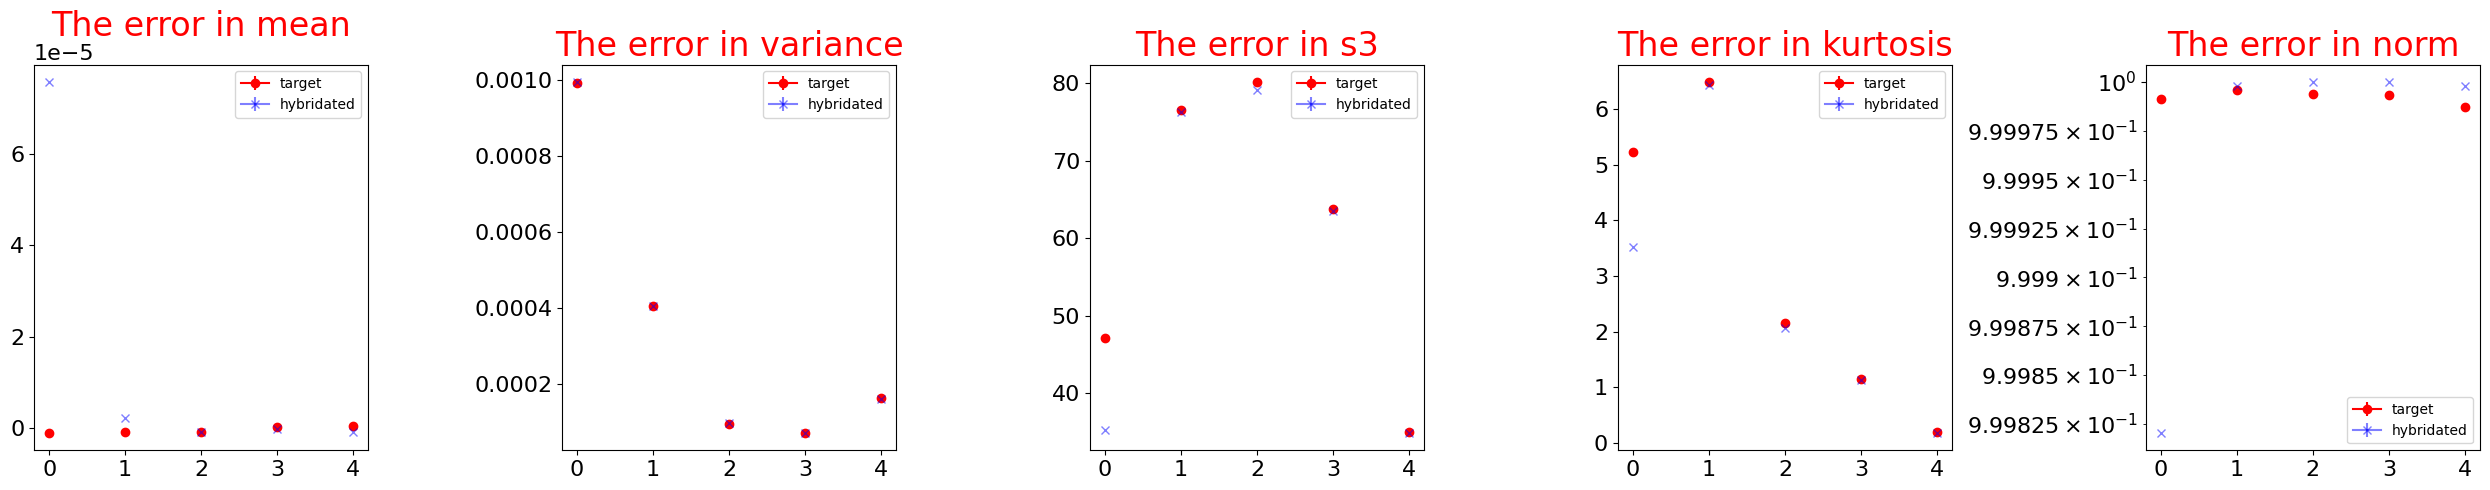

In [12]:
# fig, ax = plt.subplots(1, no_scales+2, figsize=(22, 10)) 
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.title("The error in mean")
moment = 0
plt.errorbar(0, np.mean(moments_target_full[:,moment], axis=0), yerr=np.std(moments_target_full[:,moment], axis=0),color="r", marker="o", label="target")
plt.errorbar(0, np.mean(moments_hybridated_full[:,moment], axis=0), yerr=np.std(moments_hybridated_full[:,moment], axis=0), color='blue', marker="x", alpha=0.5, label="hybridated")

for scale in range(nscales + 1):
    plt.errorbar(scale+1, np.mean(moments_target_starlet[scale, :,moment], axis=0), yerr=np.std(moments_target_starlet[scale,:,moment], axis=0),color="r", marker="o")
    plt.errorbar(scale+1, np.mean(moments_hybridated_starlet[scale,:,moment], axis=0), yerr=np.std(moments_hybridated_starlet[scale,:,moment], axis=0), color='blue', marker="x", alpha=0.5)
plt.legend()

plt.subplot(1,5,2)
plt.title("The error in variance")

moment = 1
plt.errorbar(0, np.mean(moments_target_full[:,moment], axis=0), yerr=np.std(moments_target_full[:,moment], axis=0),color="r", marker="o", label="target")
plt.errorbar(0, np.mean(moments_hybridated_full[:,moment], axis=0), yerr=np.std(moments_hybridated_full[:,moment], axis=0), color='blue', marker="x", alpha=0.5, label="hybridated")

for scale in range(nscales + 1):
    plt.errorbar(scale+1, np.mean(moments_target_starlet[scale, :,moment], axis=0), yerr=np.std(moments_target_starlet[scale,:,moment], axis=0),color="r", marker="o")
    plt.errorbar(scale+1, np.mean(moments_hybridated_starlet[scale,:,moment], axis=0), yerr=np.std(moments_hybridated_starlet[scale,:,moment], axis=0), color='blue', marker="x", alpha=0.5)
plt.legend()

plt.subplot(1,5,3)
plt.title("The error in s3")
moment = 2
plt.errorbar(0, np.mean(moments_target_full[:,moment], axis=0), yerr=np.std(moments_target_full[:,moment], axis=0),color="r", marker="o", label="target")
plt.errorbar(0, np.mean(moments_hybridated_full[:,moment], axis=0), yerr=np.std(moments_hybridated_full[:,moment], axis=0), color='blue', marker="x", alpha=0.5, label="hybridated")

for scale in range(nscales + 1):
    plt.errorbar(scale+1, np.mean(moments_target_starlet[scale, :,moment], axis=0), yerr=np.std(moments_target_starlet[scale,:,moment], axis=0),color="r", marker="o")
    plt.errorbar(scale+1, np.mean(moments_hybridated_starlet[scale,:,moment], axis=0), yerr=np.std(moments_hybridated_starlet[scale,:,moment], axis=0), color='blue', marker="x", alpha=0.5)
plt.legend()

plt.subplot(1,5,4)
plt.title("The error in kurtosis")
moment = 3
plt.errorbar(0, np.mean(moments_target_full[:,moment], axis=0), yerr=np.std(moments_target_full[:,moment], axis=0),color="r", marker="o", label="target")
plt.errorbar(0, np.mean(moments_hybridated_full[:,moment], axis=0), yerr=np.std(moments_hybridated_full[:,moment], axis=0), color='blue', marker="x", alpha=0.5, label="hybridated")

for scale in range(nscales + 1):
    plt.errorbar(scale+1, np.mean(moments_target_starlet[scale, :,moment], axis=0), yerr=np.std(moments_target_starlet[scale,:,moment], axis=0),color="r", marker="o")
    plt.errorbar(scale+1, np.mean(moments_hybridated_starlet[scale,:,moment], axis=0), yerr=np.std(moments_hybridated_starlet[scale,:,moment], axis=0), color='blue', marker="x", alpha=0.5)
plt.legend()

plt.subplot(1,5,5)
plt.title("The error in norm")
moment = 4
plt.errorbar(0, np.mean(moments_target_full[:,moment], axis=0), yerr=np.std(moments_target_full[:,moment], axis=0),color="r", marker="o", label="target")
plt.errorbar(0, np.mean(moments_hybridated_full[:,moment], axis=0), yerr=np.std(moments_hybridated_full[:,moment], axis=0), color='blue', marker="x", alpha=0.5, label="hybridated")

for scale in range(nscales + 1):
    plt.errorbar(scale+1, np.mean(moments_target_starlet[scale, :,moment], axis=0), yerr=np.std(moments_target_starlet[scale,:,moment], axis=0),color="r", marker="o")
    plt.errorbar(scale+1, np.mean(moments_hybridated_starlet[scale,:,moment], axis=0), yerr=np.std(moments_hybridated_starlet[scale,:,moment], axis=0), color='blue', marker="x", alpha=0.5)

plt.yscale('log')
plt.legend()

plt.tight_layout()

### Sturges' Formula
$
k = \lceil \log_2(n) + 1 \rceil
$

### Rice Rule
$
k = \lceil 2 \cdot n^{1/3} \rceil
$

### Scott's Rule
$
k = \frac{\text{Range}}{3.5 \cdot \sigma \cdot n^{-1/3}}
$

### Freedman-Diaconis Rule
$
k = \frac{\text{Range}}{2 \cdot \text{IQR} \cdot n^{-1/3}}
$
where IQR is the interquartile range of the data.

### Square-root Choice
$
k = \lceil \sqrt{n} \rceil
$

### Doane’s Formula
$
k = 1 + \log_2(n) + \log_2\left(1 + \frac{|g|}{\sigma_g}\right)
$
where \( g \) is the estimated skewness of the data and \( \sigma_g = \sqrt{\frac{6(n-2)}{(n+1)(n+3)}} \).

### Scott’s Normal Reference Rule
$
\text{Bin width} = \frac{3.5 \sigma}{n^{1/3}}
$



In [47]:
# from scipy.stats import iqr, skew

# def calculate_bins(image):
#     # Flatten the image to get pixel intensity values
#     data = image.flatten()
#     num_data_points = len(data)
    
#     # Sturges' Formula
#     sturges_bins = np.ceil(np.log2(num_data_points) + 1)
    
#     # Rice Rule
#     rice_bins = np.ceil(2 * num_data_points ** (1 / 3))
    
#     # Scott's Rule
#     std_dev = np.std(data)
#     scott_bins = np.ceil((data.max() - data.min()) / (3.5 * std_dev * num_data_points ** (-1 / 3)))
    
#     # Freedman-Diaconis Rule
#     iqr_value = iqr(data)
#     freedman_diaconis_bins = np.ceil((data.max() - data.min()) / (2 * iqr_value * num_data_points ** (-1 / 3)))
    
#     # Square-root Choice
#     sqrt_bins = np.ceil(np.sqrt(num_data_points))
    
#     # Doane’s Formula
#     g = skew(data)
#     sigma_g = np.sqrt((6 * (num_data_points - 2)) / ((num_data_points + 1) * (num_data_points + 3)))
#     doane_bins = np.ceil(1 + np.log2(num_data_points) + np.log2(1 + np.abs(g) / sigma_g))
    
#     # Print the number of bins calculated by each method
#     print(f"Sturges' Formula: {sturges_bins} bins")
#     print(f"Rice Rule: {rice_bins} bins")
#     print(f"Scott's Rule: {scott_bins} bins")
#     print(f"Freedman-Diaconis Rule: {freedman_diaconis_bins} bins")
#     print(f"Square-root Choice: {sqrt_bins} bins")
#     print(f"Doane’s Formula: {doane_bins} bins")
    
#     # Plot the histogram with different number of bins for comparison
#     fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    
#     axs[0, 0].hist(data, bins=int(sturges_bins), color='blue', edgecolor='black')
#     axs[0, 0].set_title(f"Sturges' Formula: {sturges_bins} bins")
    
#     axs[0, 1].hist(data, bins=int(rice_bins), color='green', edgecolor='black')
#     axs[0, 1].set_title(f"Rice Rule: {rice_bins} bins")
    
#     axs[0, 2].hist(data, bins=int(scott_bins), color='red', edgecolor='black')
#     axs[0, 2].set_title(f"Scott's Rule: {scott_bins} bins")
    
#     axs[1, 0].hist(data, bins=int(freedman_diaconis_bins), color='purple', edgecolor='black')
#     axs[1, 0].set_title(f"Freedman-Diaconis Rule: {freedman_diaconis_bins} bins")
    
#     axs[1, 1].hist(data, bins=int(sqrt_bins), color='orange', edgecolor='black')
#     axs[1, 1].set_title(f"Square-root Choice: {sqrt_bins} bins")
    
#     axs[1, 2].hist(data, bins=int(doane_bins), color='cyan', edgecolor='black')
#     axs[1, 2].set_title(f"Doane’s Formula: {doane_bins} bins")
    
#     plt.tight_layout()
#     plt.show()



# # Calculate bins and plot histograms
# calculate_bins(target)

# for scale in range(nscales + 1):
#    calculate_bins(target_starlet[scale])

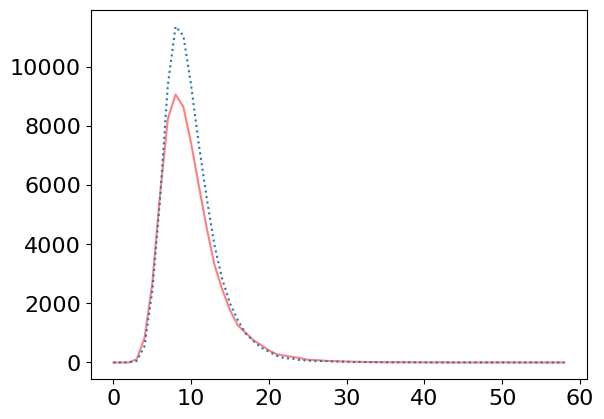

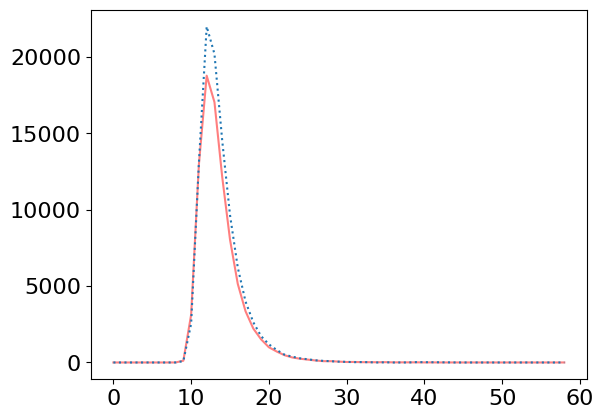

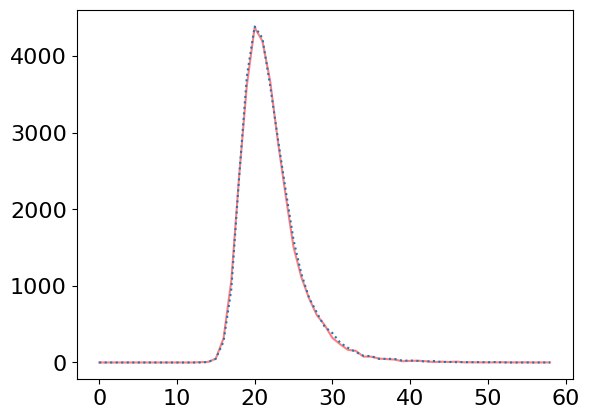

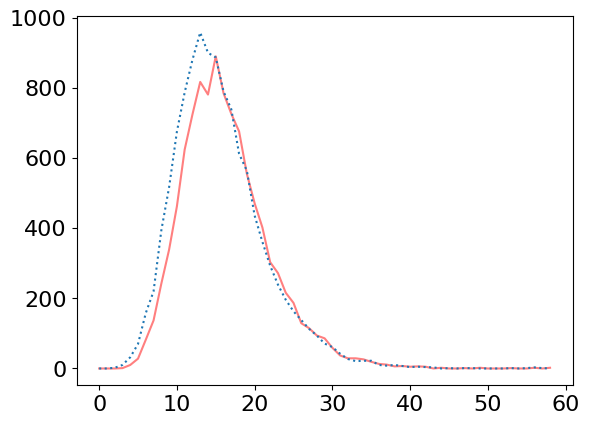

In [5]:

data_, angle_ = load_data_slics(file_no=start)
target_results = get_target_values(data_, angle_, ell_min, ell_max, cls_bins, nscales, pdf_bins, filter=filter)

target = target_results["target"]
angle = target_results["angle"]
nscales = target_results["nscales"]
ell_min = target_results["ell_min"]
ell_max = target_results["ell_max"]
cls_bins = target_results["cls_bins"]
pdf_bins = target_results["pdf_bins"]
target_starlet_cls = target_results["target_starlet_cls"]
target_ell_edges = target_results["target_ell_edges"]
target_ell_bins = target_results["target_ell_bins"]
target_cls_values = target_results["target_cls_values"]
target_starlet = target_results["target_starlet"]
target_edges = target_results["target_edges"]
target_bin_centers = target_results["target_bin_centers"]
target_pdf = target_results["target_pdf"]
target_cdf = target_results["target_cdf"]
target_starlet_edges = target_results["target_starlet_edges"]
target_starlet_bin_centers = target_results["target_starlet_bin_centers"]
target_starlet_pdf = target_results["target_starlet_pdf"]
target_starlet_cdf = target_results["target_starlet_cdf"]
    
def get_peaks(image, bins=None):
    counts, bin_edges = peaks_histogram(image, bins=bins, mask=None)
    return counts, bin_edges

target_counts, target_edges = get_peaks(target, bins=60)
hyb_counts, hyb_edges = get_peaks(corrected_full_map, bins=target_edges)

plt.figure()
plt.plot(target_counts, c="r",alpha=0.5)
plt.plot(hyb_counts, ls=":")

for scale in range(nscales + 1):
    target_counts, target_edges = get_peaks(target_starlet[scale], bins=60)
    hyb_counts, hyb_edges = get_peaks(corrected_wavelet[scale], bins=target_edges)

    plt.figure()
    plt.plot(target_counts, c="r",alpha=0.5)
    plt.plot(hyb_counts, ls=":")